In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
import imgaug.augmenters as iaa
import cv2
import os
import h5py
print(f"tf version: {tf.__version__}")
!nvcc --version

tf version: 2.6.4
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


# Data Loading Functions

In [2]:
def load_data():
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    val_x = []
    val_y = []
    
    label_norm = np.array([1, 0, 0])
    label_viral = np.array([0, 1, 0])
    label_bacterial = np.array([0, 0, 1])
    for j in ["NORMAL", "PNEUMONIA"]:
        for t in os.listdir(f"/kaggle/input/chest-xray-pneumonia/chest_xray/train/{j}/"):
            train_x.append(t)
            if("virus" in t):
                train_y.append(label_viral)
            elif("bacteria" in t):
                train_y.append(label_bacterial)
            else:
                train_y.append(label_norm)
            
        for v in os.listdir(f"/kaggle/input/chest-xray-pneumonia/chest_xray/val/{j}/"):
            val_x.append(v)
            if("virus" in v):
                val_y.append(label_viral)
            elif("bacteria" in v):
                val_y.append(label_bacterial)
            else:
                val_y.append(label_norm)
                
        for t in os.listdir(f"/kaggle/input/chest-xray-pneumonia/chest_xray/test/{j}/"):
            test_x.append(t)
            if("virus" in t):
                test_y.append(label_viral)
            elif("bacteria" in t):
                test_y.append(label_bacterial)
            else:
                test_y.append(label_norm)
    
    order = np.arange(len(train_x))
    np.random.shuffle(order)
    
    temp_x = []
    temp_y = []
    for o in order:
        temp_x.append(train_x[o])
        temp_y.append(train_y[o])
        
    return temp_x, temp_y, val_x, val_y, test_x, test_y

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, dir_name, batch_size=1):
        self.x = x
        self.y = y
        self.dir_name = dir_name
        self.batch_size = batch_size
        self.IMAGE_SIZE = (1200, 1200)

    def __len__(self):
        """Return the number of batches available."""
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        if (self.y[idx][0] == 1):
            name = "NORMAL"
        else:
            name = "PNEUMONIA"
        return np.expand_dims(cv2.resize(cv2.imread(f"/kaggle/input/chest-xray-pneumonia/chest_xray/{self.dir_name}/{name}/{self.x[idx]}"), self.IMAGE_SIZE), axis=0), np.array([self.y[idx]])



# Model Generators

In [ ]:
def build_alexnet(input_shape):
    inputs = Input(input_shape)
    
    # Block 1
    c1 = Conv2D(48, kernel_size=(11,11), strides=(11, 11))(inputs) 
    p1 =  MaxPool2D((3, 3), strides=2)(c1)
    
    #Block 2
    c2 = Conv2D(128, kernel_size=(5,5), padding="same")(p1)
    p2 =  MaxPool2D((3, 3), strides=2)(c2)
    
    #Block 3
    c3 = Conv2D(192, kernel_size=(3,3), padding="same")(p2)
    c4 = Conv2D(192, kernel_size=(3,3), padding="same")(c3)
    c5 = Conv2D(128, kernel_size=(3,3), padding="same")(c4)
    
    p3 =  MaxPool2D((3, 3),strides=2)(c5)
    
    top_out = Flatten()(p3)
    
    # Block 1 mirror
    vc1 = Conv2D(48, kernel_size=(11,11), strides=(11, 11))(inputs) 
    vp1 =  MaxPool2D((3, 3), strides=2)(vc1)
    
    #Block 2 mirror
    vc2 = Conv2D(128, kernel_size=(5,5), padding="same")(vp1)
    vp2 =  MaxPool2D((3, 3), strides=2)(vc2)
    
    #Block 3 mirror
    vc3 = Conv2D(192, kernel_size=(3,3), padding="same")(vp2)
    vc4 = Conv2D(192, kernel_size=(3,3), padding="same")(vc3)
    vc5 = Conv2D(128, kernel_size=(3,3), padding="same")(vc4)
    
    vp3 =  MaxPool2D((3, 3),strides=2)(vc5)
    
    bot_out = Flatten()(vp3)
    
    # Fully Connected Layers
    u_in = Concatenate(axis=1)([top_out, bot_out])
    b_in = Concatenate(axis=1)([bot_out, top_out])
    
    
    ufc1 = Dense(2048, activation="relu", kernel_initializer="random_normal")(u_in)
    bfc1 = Dense(2048, activation="relu", kernel_initializer="random_normal")(b_in)
    
    u2_in = Concatenate(axis=1)([ufc1, bfc1])
    b2_in = Concatenate(axis=1)([bfc1, ufc1])
    
    ufc2 = Dense(2048, activation="relu", kernel_initializer="random_normal")(u2_in)
    bfc2 = Dense(2048, activation="relu", kernel_initializer="random_normal")(b2_in)
    
    pen = Concatenate(axis=1)([ufc2, bfc2])
    
    outputs = Dense(3, activation="softmax", kernel_initializer="random_normal")(pen)
    
    alexnet = Model(inputs, outputs, name="Alexnet")
    
    return alexnet

def build_resnet(input_shape):
    
    return ResNet50(include_top=True, classes=3, weights=None, input_shape=input_shape)


def build_inceptionresnet(input_shape):
    
    return InceptionResNetV2(include_top=True, classes=3, weights=None, input_shape=input_shape)


def build_inceptionnet(input_shape):
    
    return InceptionV3(include_top=True, classes=3, weights=None, input_shape=input_shape)

# Visualization

(1, 1200, 1200, 3) [[0 0 1]]


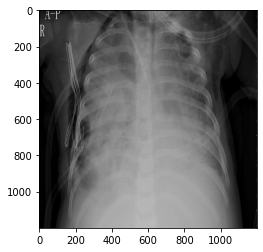

In [3]:
train_x, train_y, val_x, val_y, test_x, test_y = load_data()
train_datagen = DataGenerator(train_x, train_y, "train")
val_datagen = DataGenerator(val_x, val_y, "val")
print(train_datagen[0][0].shape, train_datagen[0][1])
plt.imshow(train_datagen[0][0][0])

In [4]:
model = build_alexnet(train_datagen[0][0][0].shape)
model.summary()

2022-08-04 10:50:25.700219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 10:50:25.845045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 10:50:25.846042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 10:50:25.847987: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Alexnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1200, 1200,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 48) 17472       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 109, 109, 48) 17472       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 54, 54, 48)   0           conv2d[0][0]                     
____________________________________________________________________________________________

# Training

In [7]:
initial_lr = 1e-3

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_delta=1e-2),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, min_delta=1e-2),
    tf.keras.callbacks.ModelCheckpoint('/kaggle/working/alexnet_model.h5', save_best_only=True, monitor='val_acc', mode='max')
]

history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=30,
    callbacks=callbacks
)

log = pd.DataFrame()
log["loss"] = history.history["loss"]
log["acc"] = history.history["acc"]
log["val_loss"] = history.history["val_loss"]
log["val_acc"] = history.history["val_acc"]
log.to_csv("/kaggle/working/alexnet_log.csv")

Epoch 1/30
5216/5216 [==============================] - 157s 30ms/step - loss: 85341328.0000 - acc: 0.4749 - val_loss: 1.0466 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 157s 30ms/step - loss: 1.0516 - acc: 0.4850 - val_loss: 1.0254 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 156s 30ms/step - loss: 1.0518 - acc: 0.4850 - val_loss: 1.0601 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 155s 30ms/step - loss: 1.0512 - acc: 0.4850 - val_loss: 1.0319 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 153s 29ms/step - loss: 1.0507 - acc: 0.4850 - val_loss: 1.0305 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 154s 29ms/step - loss: 1.0513 - acc: 0.4850 - val_loss: 1.0368 - val_acc: 0.5000
Epoch 7/30
5216/5216 [==============================] - 155s 30ms/step - loss: 1.0504 - acc: 0.4850 - val_loss: 1.0159 - val_acc: 0.5000
Epoch 8/30
5216/5216 [============

# Test Data Prediction Accuracy

In [8]:
test_datagen = DataGenerator(test_x, test_y, "test")
result = []
for i in range(len(test_datagen)):
    pred = model.predict(test_datagen[i][0])
    if(pred.max() == pred[0][0]):
        if(test_datagen[i][1][0][0] == 1):
            result.append(1)
        else: 
            result.append(0)
    elif(pred.max() == pred[0][1]):
        if(test_datagen[i][1][0][1] == 1):
            result.append(1)
        else: 
            result.append(0)
    else:
        if(test_datagen[i][1][0][2] == 1):
            result.append(1)
        else: 
            result.append(0)
print(np.mean(result))

0.38782051282051283
